In [41]:
import glob
import numpy as np
import pandas as pd
import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import src as ddfa_node

while True:
    losses = []
    iters = []

    files = glob.glob("/home/michael/Synology/Python/Gait-Signatures/ray_results/pb2_lovelace/**/progress.csv", recursive=True)
    for file in files:
        df = pd.read_csv(file)
        max_iterations = df["training_iteration"].max()
        if max_iterations >= 5:
            selected_rows = df[df.apply(lambda row: row["training_iteration"] == max_iterations, axis=1)]

            losses.append(selected_rows["total_val_loss"].max())
            iters.append(max_iterations)
    losses = np.abs(losses)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].hist(losses[losses < 0.5],bins=10)
    ax[0].set_xlabel("Loss")
    ax[0].set_ylabel("Count")
    ax[0].set_xlim([0, 0.6])

    ax[1].hist(np.abs(iters),bins=10)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()
    display.clear_output(wait=True)
    time.sleep(30)
    

KeyboardInterrupt: 

In [ ]:
glob.glob(files[np.argmax(losses)][:-12])

## Import packages and set environment variables

In [1]:
import os
# os.environ["R_HOME"] = "/home/michael/anaconda3/envs/torch/lib/R"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import src as ddfa_node
import matplotlib.pyplot as plt
import importlib
import torch
importlib.reload(ddfa_node)
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline

## Load and prepare data

In [4]:
data_path = "/home/michael/Synology/Julia/data/human_data.npy"
data = ddfa_node.load_data_normalize(6, '/home/michael/Synology/Julia/data/human_data.npy')

[-2.60532336e-17  3.07901852e-17]


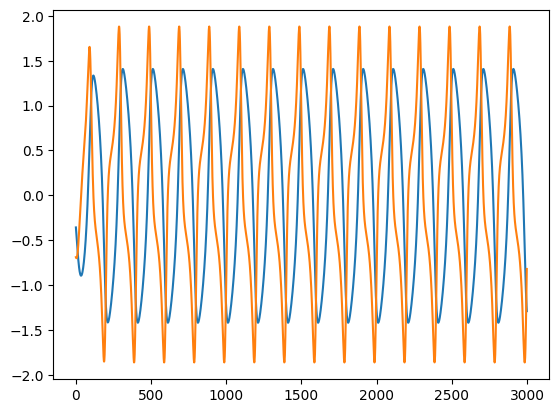

In [39]:
from scipy import stats
data = stats.zscore(np.load("data/van_der_pol.npy"), axis=1)
dimension_axis = 1

# Apply z-scoring along the dimensions axis
zscored_data = np.apply_along_axis(stats.zscore, dimension_axis, data)
print(zscored_data[0].mean(axis=0))
plt.plot(zscored_data[0])

## Taken's Embed the data with optimal parameters

In [41]:
time_delayed_data, k, τ = ddfa_node.embed_data(zscored_data[:, :, :], maxlags=500)
print(time_delayed_data.shape)
# τ, k = 19, 5
# time_delayed_data = ddfa_node.takens_embedding(data, τ, k)

Data has been embedded using a delay of 35 timesteps and an embedding dimension of 2
(48, 2930, 6)


## Train models

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Subsample whole trials to smaller ones
timesteps_per_sample = 1500
all_data = ddfa_node.change_trial_length(time_delayed_data, timesteps_per_subsample=timesteps_per_sample, skip=50)

# Train/test splitting
train_size = 0.7
data_train, data_val = ddfa_node.split_data(all_data, train_size=train_size)

# Add noise to data
noise_std = 0.2
data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=5, noise_std=noise_std)

data_train, data_val = torch.from_numpy(data_train).float().to(device), torch.from_numpy(data_val).float().to(device)

ts_num = 100.0
tot_num = data_train.shape[1]

samp_ts = np.linspace(0, ts_num, num=tot_num)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

val_num = ts_num / tot_num * data_val.shape[1]
val_ts = np.linspace(0, val_num, data_val.shape[1])
val_ts = torch.from_numpy(val_ts).float().to(device)

In [20]:
import h5py
hf = h5py.File('/home/michael/Code/TMLR_GOKU-UI/Experiments/scripts/Training/Baselines/LatentODE/sims/rimless_wheel.h5', 'w')
hf.create_dataset('training/high_dim_data', data=data_train.cpu())
hf.create_dataset('validation/high_dim_data', data=data_val.cpu())
hf.close()

In [25]:
batch_size = 64
latent_dim = 16
n_hidden = 64
dec_hidden = 64
obs_dim = data_train.shape[-1]
rnn_hidden = 256
n_itrs = 600
lr = 8e-3
dropout = 0.2

In [ ]:
# train from scratch:
func, rec, dec, train_losses, val_losses, val_mses = ddfa_node.train_network(data_train=data_train, 
                                                                             data_val=data_val, 
                                                                             device=device, 
                                                                             samp_ts=samp_ts,
                                                                             val_ts=val_ts, 
                                                                             n_itrs=n_itrs, 
                                                                             latent_dim=latent_dim, 
                                                                             n_hidden=n_hidden, 
                                                                             obs_dim=obs_dim, 
                                                                             rnn_hidden=rnn_hidden, 
                                                                             dec_hidden=dec_hidden, 
                                                                             batch_size=batch_size, 
                                                                             lr=lr, 
                                                                             dropout=dropout, 
                                                                             noise_std=noise_std)

Iter: 0, total loss: 2.1500933170318604, kl_loss: 1.10948828125, mse_loss: 1.040605068206787 val loss: 2.072688102722168, val_kl: 1.0684765625000001, val_mse: 1.00421142578125
Iter: 5, total loss: 1.7774826288223267, kl_loss: 0.9147279687500001, mse_loss: 0.8627547025680542 val loss: 1.766060471534729, val_kl: 0.9088117187500001, val_mse: 0.8572487831115723
Iter: 10, total loss: 1.5935640335083008, kl_loss: 0.81923953125, mse_loss: 0.7743245363235474 val loss: 1.5077908039093018, val_kl: 0.773812890625, val_mse: 0.7339779734611511
Iter: 15, total loss: 1.4913740158081055, kl_loss: 0.7655984375000001, mse_loss: 0.7257756590843201 val loss: 1.4111599922180176, val_kl: 0.7231195312500001, val_mse: 0.6880404949188232
Iter: 20, total loss: 1.3580093383789062, kl_loss: 0.6960570312500001, mse_loss: 0.6619522571563721 val loss: 1.2570215463638306, val_kl: 0.6425097265625, val_mse: 0.6145118474960327
Iter: 25, total loss: 1.4104573726654053, kl_loss: 0.7244672656250001, mse_loss: 0.68599021434

In [50]:
# further train existing model
func, rec, dec, train_losses, val_losses, val_mses = ddfa_node.train_network(func=func, rec=rec, dec=dec, data_train=data_train, data_val=data_val, device=device, samp_ts=samp_ts, val_ts=val_ts, n_itrs=n_itrs, latent_dim=latent_dim, n_hidden=n_hidden, obs_dim=obs_dim, rnn_hidden=rnn_hidden, dec_hidden=dec_hidden, batch_size=batch_size, lr=lr, dropout=dropout, noise_std=noise_std)

Iter: 0, total loss: 0.20984941720962524, kl_loss: 0.0997650390625, mse_loss: 0.11008438467979431 val loss: 0.14792978763580322, val_kl: 0.06591076171875, val_mse: 0.08201903104782104
Iter: 5, total loss: 0.34249168634414673, kl_loss: 0.17213589843750002, mse_loss: 0.17035578191280365 val loss: 0.31818243861198425, val_kl: 0.15882183593750002, val_mse: 0.1593606024980545
Iter: 10, total loss: 0.410361647605896, kl_loss: 0.20913533203125, mse_loss: 0.20122630894184113 val loss: 0.2816523611545563, val_kl: 0.13888052734375, val_mse: 0.14277184009552002
Iter: 15, total loss: 0.36024945974349976, kl_loss: 0.18180542968750002, mse_loss: 0.1784440129995346 val loss: 0.3308817446231842, val_kl: 0.16579548828125001, val_mse: 0.16508625447750092
Training interrupted. Current model's loss:
Iter: 19, running avg mse: 0.32268232107162476, val_loss: 0.14747361838817596


ValueError: too many values to unpack (expected 5)

## Evaluate model

In [27]:
class NODE(torch.nn.Module):
    def __init__(self, func, rec, dec, latent_dim, odeint, samp_ts, device, noise_std=0.15):
        super(NODE, self).__init__()
        self.func = func
        self.rec = rec
        self.dec = dec
        self.latent_dim = latent_dim
        self.odeint = odeint
        self.samp_ts = samp_ts
        self.device = device
        self.noise_std = noise_std

    def forward(self, x):
        h = self.rec.initHidden().to(self.device)
        c = self.rec.initHidden().to(self.device)
        hn = h[0, :, :]
        cn = c[0, :, :]
        for t in reversed(range(x.shape[1])):
            obs = x[:, t, :]
            out, hn, cn = self.rec.forward(obs, hn, cn)
        qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(self.device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        z0 += torch.rand(*z0.shape).to(self.device) * self.noise_std

        # forward in time and solve ode for reconstructions
        pred_z = self.odeint(self.func, z0, self.samp_ts).permute(1, 0, 2)
        pred_x = self.dec(pred_z)

        return pred_x, z0, qz0_mean, qz0_logvar

In [ ]:
import torch
from torchdiffeq import odeint
dropout = 0.0
model_path = "/home/michael/Synology/Python/Gait-Signatures/ray_results/pb2_lovelace/train_convnet_ebece_00027_27_alpha=0.0002,batch_size=32,dec_dropout=0.1583,latent_dim=16,lr=0.0070,rnn_hidden=128,timesteps_per_tr_2024-04-02_01-40-01/checkpoint_000012/checkpoint.pt"
state_dict = torch.load(model_path)
# func, rec, dec = ddfa_node.LatentODEfunc(latent_dim, n_hidden, dropout).to(device), ddfa_node.RecognitionRNN(latent_dim, obs_dim, rnn_hidden, dropout, batch_size).to(device), ddfa_node.Decoder(latent_dim, obs_dim, dec_hidden, dropout).to(device)
model = NODE(func, rec, dec, latent_dim, odeint, samp_ts, device, noise_std=0.4)
# model.load_state_dict(state_dict["model_state_dict"])

In [29]:
model.rec.nbatch = data.shape[0]
model.rec.dropout, model.dec.dropout = torch.nn.Dropout(0.0), torch.nn.Dropout(0.0)
model.func.noise_std = 0.05
model.func.device = device
new_data_size = 10000
dt = np.diff(samp_ts.cpu())[0]

new_ts = np.arange(0, new_data_size*dt, step=dt)
new_ts = torch.from_numpy(new_ts).float().to(device)
model.samp_ts = new_ts
pred, _, _, _ = model(torch.from_numpy(time_delayed_data[:, :timesteps_per_sample, :]).float().to(device))

In [110]:
pred = pred[:, ::3, :]

In [96]:
np.save("/home/michael/Synology/Python/Gait-Signatures/NeuralODE/DDFA_NODE/data/VDP_gen_data.npy", pred.detach().cpu()[:, ::3, :])

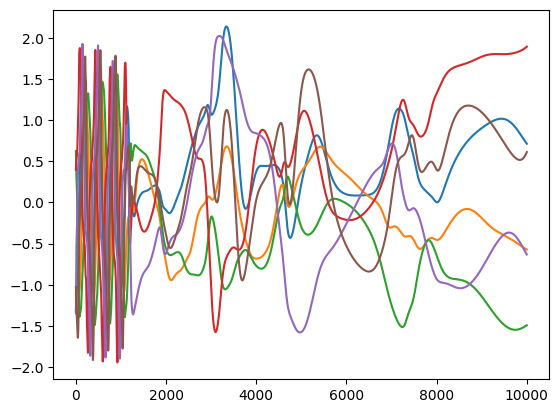

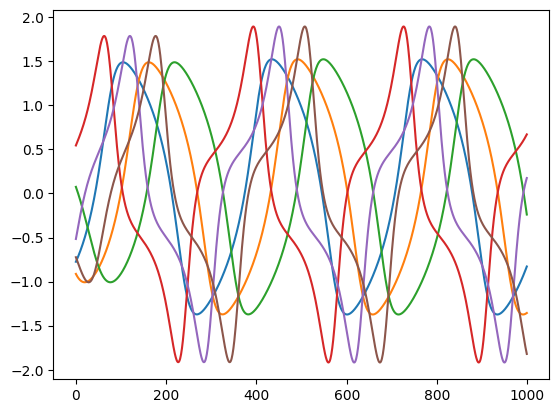

In [36]:
%matplotlib inline
plt.plot(pred[20, :, :].detach().cpu())
plt.show()
plt.plot(time_delayed_data[10, :1000, :])
# plt.scatter(pred[10, :, 0].detach().cpu(), pred[10, :, 34].detach().cpu())

In [7]:
%matplotlib inline

plt.plot(train_losses, label="Training Loss")
plt.plot(val_mses, label="Validation Loss")
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

In [16]:
%matplotlib inline
from torchdiffeq import odeint

all_data = torch.from_numpy(time_delayed_data[:, :timesteps_per_sample, :]).float().to(device)
new_data_size = timesteps_per_sample
dt = np.diff(samp_ts.cpu())[0]

new_ts = np.arange(0, new_data_size*dt, step=dt)
new_ts = torch.from_numpy(new_ts).float().to(device)

h = torch.zeros(1, data.shape[0], rnn_hidden).to(device)
c = torch.zeros(1, data.shape[0], rnn_hidden).to(device)

hn = h[0, :, :]
cn = c[0, :, :]

for t in reversed(range(all_data.shape[1])):
    obs = all_data[:, t, :]
    out, hn, cn = rec.forward(obs, hn, cn)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, new_ts).permute(1, 0, 2) #change time and batch with permute
pred_x = dec(pred_z)

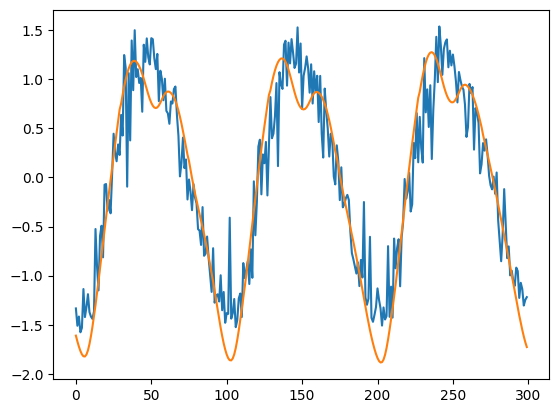

In [18]:
plt.plot(pred_x[10, :, 0].detach().cpu())
plt.plot(time_delayed_data[10, :timesteps_per_sample, 0])

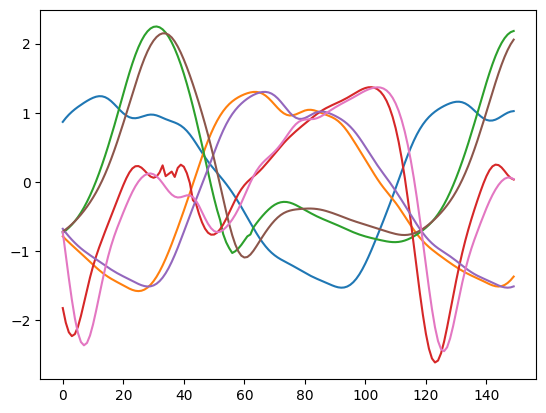

In [26]:
plt.plot(time_delayed_data[0, :timesteps_per_sample, ::k])
plt.show()

In [ ]:
metrics = model.evaluate()

## Get self-driven data

In [ ]:
self_generated_data = ddfa_node.generate_data_from_model(model, steps=5000)

## Estimate Floquet multipliers

In [ ]:
λs = ddfa_node.get_FM(self_generated_data)

## Visualize Floquet multipliers

In [ ]:
ddfa_node.make_FM_plots(λs)